In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#needed for jupyter notebook
#https://github.com/tensorflow/tensorflow/issues/24828
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs Available:  3


In [2]:
# https://github.com/jkjung-avt/keras-cats-dogs-tutorial/blob/master/train_resnet50.py
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# resnet versions
# from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input

# graph
import matplotlib.pyplot as plt

#conf mat
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import time, os
from tensorflow.keras.preprocessing import image

In [3]:
"""
global hyperparameters + filenames
"""
DATASET_PATH = "may_split"

# height = 2*width
# TARGET_SIZE = height, width 
TARGET_SIZE = (224,112) 

print("DATASET_PATH: ", DATASET_PATH)
print("TARGET_SIZE: ", TARGET_SIZE)

DATASET_PATH:  may_split
TARGET_SIZE:  (224, 112)


In [4]:
def train_network(cs_num, b_range=(0.8, 1.0)):
    BATCH_SIZE = 16
#     BATCH_SIZE = 32  
    
    """
    augmenting data
    """
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=0,
        shear_range=10,

        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.3,

        brightness_range=b_range,
        channel_shift_range=cs_num,

        horizontal_flip=True,
    )

    # train_datagen.reset()

    train_batches = train_datagen.flow_from_directory(
        DATASET_PATH + "/train",
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
    #     interpolation='bicubic',
        class_mode='categorical',
        shuffle=True)

    valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # valid_datagen.reset()

    valid_batches = valid_datagen.flow_from_directory(
        DATASET_PATH + "/valid",
        target_size=TARGET_SIZE, 
        batch_size=BATCH_SIZE,
    #     interpolation='bicubic',
        class_mode='categorical',
        shuffle=True)


    """
    training nnet
    """
    #hyperparams
    #try reducing batch size (top) or freeze more layers if your GPU runs out of memory
    NUM_CLASSES = len(train_batches.class_indices.items())
    
    NUM_EPOCHS = 15
    
    FREEZE_LAYERS = 101 # 2 + 3*33
#     FREEZE_LAYERS = 35 # 2 + 3*11

    print("hyperparameters:")
    print("cs_num: ", cs_num)
    print("b_range: ", b_range)
    print("BATCH_SIZE: ", BATCH_SIZE)
    print("NUM_CLASSES: ", NUM_CLASSES)
    print("FREEZE_LAYERS: ", FREEZE_LAYERS)
    print("NUM_EPOCHS: ", NUM_EPOCHS)
    
    # https://github.com/jkjung-avt/keras-cats-dogs-tutorial/blob/master/train_resnet50.py

    net = ResNet152V2(include_top=False, weights='imagenet', input_tensor=None,
                   input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3))
#     net = ResNet50V2(include_top=False, weights='imagenet', input_tensor=None,
#                    input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3))
    x = net.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
    net_final = Model(inputs=net.input, outputs=output_layer)

    #freeze layers
    for layer in net_final.layers[:FREEZE_LAYERS]:
        layer.trainable = False
    for layer in net_final.layers[FREEZE_LAYERS:]:
        layer.trainable = True

    net_final.compile(optimizer=Adam(lr=1e-5, beta_1=0.99),
                      loss='categorical_crossentropy', metrics=['accuracy'])

    # train the model
    history = net_final.fit(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps = valid_batches.samples // BATCH_SIZE,
                            epochs = NUM_EPOCHS)
    return net_final, history

In [5]:
from datetime import datetime
def custom_save_model(net_final, cs_num, br_range):
    # get current date and time
    now = datetime.now()
    dt_string = now.strftime("%m.%d") #month.day to save all correlated models to same dir
    
    print("Timestamp:", dt_string)
    MODELS_PATH = os.path.join("saved_models", dt_string)
    if not os.path.exists(MODELS_PATH):
        os.mkdir(MODELS_PATH)

    model_filename = "{}cs_{}br_{}_RES152V2.h5".format(cs_num, br_range, DATASET_PATH)
    filepath = os.path.join(MODELS_PATH, model_filename)
    net_final.save(filepath)
    print("Model saved at:", filepath)

In [6]:
def graph_history(history):
    # plot acc
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def print_finals(history):
    print("final metrics:")
    for key, val_list in history.history.items():
        print("{}: {}".format(key, val_list[-1]))
    print()

In [7]:
def single_conf_mat(net_final):
    IMG_DIR = os.path.join(DATASET_PATH,"valid")
    ALL_CLASSES = sorted(os.listdir(os.path.join(DATASET_PATH,"valid")))

    imgs = []
    classes = []
    for cls in ALL_CLASSES: #class is Python keyword
#         print("-"*5,cls,"-"*5,"\n")
        CLASS_DIR = os.path.join(IMG_DIR, cls)
        for filename in os.listdir(CLASS_DIR):
            img_path = os.path.join(CLASS_DIR, filename)

            img = image.load_img(img_path, target_size=TARGET_SIZE)
            if not img: continue
            x = image.img_to_array(img)
            x = preprocess_input(x)

            imgs.append(x)
            classes.append(ALL_CLASSES.index(cls))

    imgs = np.asarray(imgs)
    classes = np.asarray(classes)

    print(imgs.shape)
    print(classes.shape)
    Y_pred = net_final.predict(imgs)
    y_pred = np.argmax(Y_pred, axis=1)

    print('Confusion Matrix')
    print(confusion_matrix(classes, y_pred))

In [8]:
def ensemble_conf_mat(ens_list):
    IMG_DIR = os.path.join(DATASET_PATH,"valid")
    ALL_CLASSES = sorted(os.listdir(os.path.join(DATASET_PATH,"valid")))

    imgs = []
    classes = []
    for cls in ALL_CLASSES: #class is Python keyword
#         print("-"*5,cls,"-"*5,"\n")
        CLASS_DIR = os.path.join(IMG_DIR, cls)
        for filename in os.listdir(CLASS_DIR):
            img_path = os.path.join(CLASS_DIR, filename)

            img = image.load_img(img_path, target_size=TARGET_SIZE)
            if not img: continue
            x = image.img_to_array(img)
            x = preprocess_input(x)

            imgs.append(x)
            classes.append(ALL_CLASSES.index(cls))
    imgs = np.asarray(imgs)
    classes = np.asarray(classes)
    print(imgs.shape)
    print(classes.shape)
    
    first_nnet = True
    combined_Y_pred = None
    for nnet in ens_list:
        Y_pred = nnet.predict(imgs)
        if first_nnet:
            combined_Y_pred = Y_pred
            first_nnet = False
        else:
            combined_Y_pred += Y_pred #should add element-wise
    
    combined_y_pred = np.argmax(Y_pred, axis=1)
    
    print('Confusion Matrix')
    print(confusion_matrix(classes, combined_y_pred))
    
    print("Accuracy")
    print(accuracy_score(classes, combined_y_pred))

[90]
[(0.75, 1.0)]
Found 16176 images belonging to 13 classes.
Found 4037 images belonging to 13 classes.
hyperparameters:
cs_num:  90
b_range:  (0.75, 1.0)
BATCH_SIZE:  16
NUM_CLASSES:  13
FREEZE_LAYERS:  101
NUM_EPOCHS:  15
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1011 steps, validate for 252 steps
Epoch 1/15
1011/1011 [==============================] - 152s 150ms/step - loss: 1.2637 - accuracy: 0.6750 - val_loss: 0.2200 - val_accuracy: 0.9301
Epoch 2/15
1011/1011 [==============================] - 137s 135ms/step - loss: 0.2845 - accuracy: 0.9133 - val_loss: 0.0418 - val_accuracy: 0.9864
Epoch 3/15
1011/1011 [==============================] - 137s 135ms/step - loss: 0.1204 - accuracy: 0.9636 - val_loss: 0.0173 - val_accuracy: 0.9953
Epoch 4/15
1011/1011 [==============================] - 137s 135ms/step - loss: 0.0756 - accuracy: 0.9770 - val_loss: 0.0113 - val_accuracy: 0.9973
Epoch 5/15
1011/1011 [==============================] - 137s 135ms/step - loss: 0.0524 

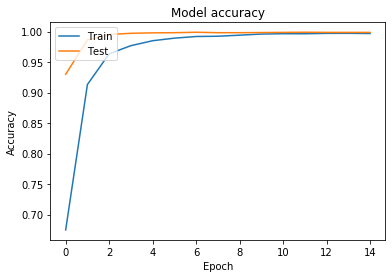

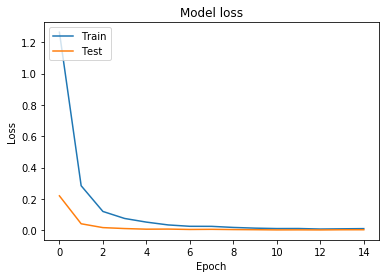

final metrics:
loss: 0.01090520417666412
accuracy: 0.9969090223312378
val_loss: 0.003758753365079664
val_accuracy: 0.998759925365448

(4037, 224, 112, 3)
(4037,)
Confusion Matrix
[[ 158    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0  117    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0  103    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0  658    0    0    1    0    0    0    1    0    0]
 [   0    0    0    0   80    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  188    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0 1400    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  146    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0  117    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0  116    0    0    0]
 [   0    0    0    0    0    0    0    0    0    1  692    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0   84    0]
 [   

In [9]:
"""
main training "method"
displays single model conf mats
TODO: split data, train three models, avg for preds, get results
"""
cs_nums = [90]
# cs_nums = [i for i in range(50, 255, 20)]
print(cs_nums)
br_ranges = [(0.75, 1.0)]
# br_ranges = [(0.50, 1.0)]
print(br_ranges)

for br_range in br_ranges:
    for cs_num in cs_nums:
        nnet, history = train_network(cs_num, br_range)
        print("cs_num: {}".format(cs_num))
        print("br_range: {}".format(br_range))
        graph_history(history)
        print_finals(history)
        single_conf_mat(nnet)
        custom_save_model(nnet, cs_num, br_range) #will save to month/day/hr directory, may cause duplicates if trained multiple time

In [12]:
"""
loads multiple models, displays conf mat of combined preds
"""

# ENS_DIR = "saved_models/04.22.19"
ENS_DIR = None
if not ENS_DIR:
    # get current date and time
    now = datetime.now()
    dt_string = now.strftime("%m.%d") #current month.day is default for saving
    ENS_DIR = os.path.join("saved_models", dt_string)

ens_list = []
for file in os.listdir(ENS_DIR):
    nnet_path = os.path.join(ENS_DIR, file)
    nnet = load_model(nnet_path)
    ens_list.append(nnet)
ensemble_conf_mat(ens_list)

(4037, 224, 112, 3)
(4037,)
Confusion Matrix
[[ 158    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0  117    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0  103    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0  658    0    0    1    0    0    0    1    0    0]
 [   0    0    0    0   80    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  188    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0 1400    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  146    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0  117    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0  116    0    0    0]
 [   0    0    0    0    0    0    0    0    0    1  692    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0   84    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  173]]
Accuracy
0.9987614565271241
